## Seminar 10. Introduction to Reinforcement Learning

<font color='red'>**Last updated: 26.03.2024**</font>


In [ ]:
import sys, os

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import random
%matplotlib inline

Let's delve into the foundational element of Reinforcement Learning (RL): the agent-environment interaction loop.

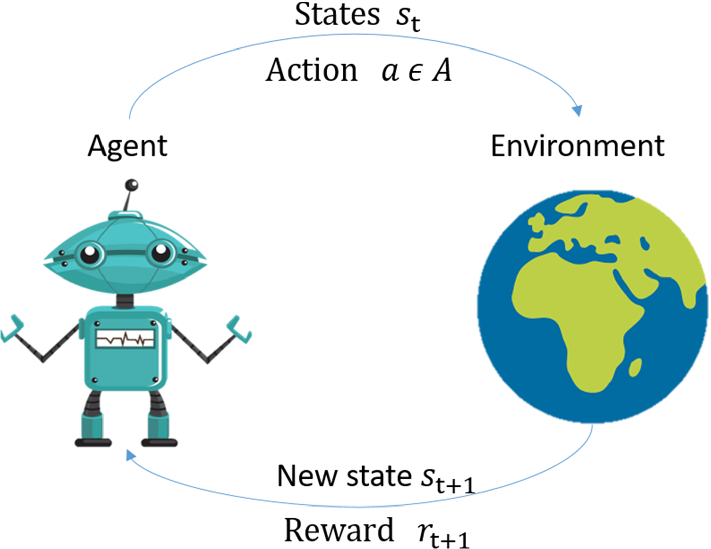

# 1. Basic Agent and Environment

To implement a reinforcement learning system, we must define both an **environment** and an **agent**. Usually, an environment has the following functions:



*   `__init__()`, i.e. a constructor.
*   `get_observation()` returns the current state observation.
*   `get_actions()`  provides the available actions for the agent.
*   `is_done()` signals episode end.
*    `action()` handles agent actions, returns a random reward, and updates the step counter, ending episodes when necessary.


Here is a basic environment that handles actions 0 and 1, operates for 10 time steps, and provides a random reward at each step.


In [ ]:
class Environment:
    def __init__(self):
        self.steps_left = 10

    def get_observation(self) -> List[float]:
        return [0.0, 0.0, 0.0]

    def get_actions(self) -> List[int]:
        return [0, 1]

    def is_done(self) -> bool:
        return self.steps_left == 0

    def action(self, action: int) -> float:
        if self.is_done():
            raise Exception("Game is over")
        self.steps_left -= 1
        return random.random()


An basic agent is much simpler and includes only two methods:

*   the constructor,
*   the `step()` function that performs one step in the environment.


The `step()` function  accepts the environment instance as an argument. On each step an agent:

1.  Observes the environment.
2.  Makes a decision about the action to take based on the observations.
3.  Submits the action to the environment.
4.  Gets the reward for the current step.







In [ ]:
class Agent:
    def __init__(self):
      self.total_reward = 0.0

    def step(self, env: Environment):
        current_obs = env.get_observation()
        print("Observation {}".format(current_obs))
        actions = env.get_actions()
        print("Actions {}".format(actions))
        reward = env.action(random.choice(actions)) # random action
        self.total_reward += reward

In [ ]:
env = Environment()
agent = Agent()

while not env.is_done():
    agent.step(env)

print("Total reward got: %.4f" % agent.total_reward)

Observation [0.0, 0.0, 0.0]
Actions [0, 1]
Observation [0.0, 0.0, 0.0]
Actions [0, 1]
Observation [0.0, 0.0, 0.0]
Actions [0, 1]
Observation [0.0, 0.0, 0.0]
Actions [0, 1]
Observation [0.0, 0.0, 0.0]
Actions [0, 1]
Observation [0.0, 0.0, 0.0]
Actions [0, 1]
Observation [0.0, 0.0, 0.0]
Actions [0, 1]
Observation [0.0, 0.0, 0.0]
Actions [0, 1]
Observation [0.0, 0.0, 0.0]
Actions [0, 1]
Observation [0.0, 0.0, 0.0]
Actions [0, 1]
Total reward got: 4.5042


# 2. NP problems

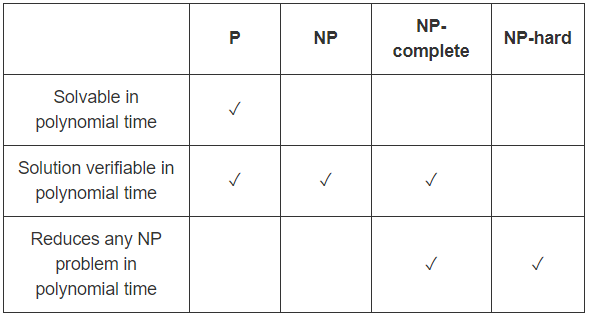

A potential application of RL algorithms in mathematics is the solution of NP problems. We will now consider a classical problem as an illustration.


> **Traveling Salesman Problem** (TSP). Given a complete weighted graph $G = (V, E)$, find a tour of minimum total weight, i.e. a cycle of minimum length that visits each node of the graph exactly once.

We'll generate a random graph with $N=7$ vertices. Existing edges have random weights from $1$ to $100$. Non-existent edges are assigned a large weight  $\operatorname{INF} = 10^5$, for completeness.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

# Large weight
INF_WEIGHT = 10**5

Graph generator

In [ ]:
def generate_graph_with_min_degree_2(num_vertices, prob=0.5):
  """Generates a graph where each vertex has a degree of at least 2."""
  graph = nx.Graph()
  for i in range(num_vertices):
      graph.add_node(i)

  # Random edges with probability prob
  for i in range(num_vertices):
    for j in range(i + 1, num_vertices):
      if random.random() < prob:  # Add an edge with probability prob
        weight = random.randint(1, 100)
        graph.add_edge(i, j, weight=weight)

  # Ensure min degree 2
  for i in range(num_vertices):
    if graph.degree[i] < 2:
      neighbors = list(graph.neighbors(i))
      if len(neighbors) == 0:
        other_nodes = [n for n in graph.nodes if n != i]
        if len(other_nodes) >= 2:
          weight = random.randint(1, 100)
          graph.add_edge(i, other_nodes[0], weight=weight)
          weight = random.randint(1, 100)
          graph.add_edge(i, other_nodes[1], weight=weight)
      elif len(neighbors) == 1:
        other_nodes = [n for n in graph.nodes if n != i and n not in neighbors]
        if len(other_nodes) >= 1:
          weight = random.randint(1, 100)
          graph.add_edge(i, other_nodes[0], weight=weight)

  return graph




def draw_graph(graph, inf_weight=INF_WEIGHT):
  """Draws the graph."""
  plt.figure(figsize=(8, 4))
  pos = nx.spring_layout(graph)

  # No edges with INF_WEIGHT
  edges_to_draw = [(u, v) for u, v, data in graph.edges(data=True) if data['weight'] != inf_weight]
  labels = {(u, v): data['weight'] for u, v, data in graph.edges(data=True) if data['weight'] != inf_weight}

  nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=500, edgelist=edges_to_draw,
          edge_cmap=plt.cm.Blues, width=2)
  nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
  plt.show()


def get_weight_matrix(graph):
  """Returns the weight matrix of the graph."""
  num_vertices = len(graph.nodes)
  weight_matrix = np.full((num_vertices, num_vertices), 10**5)  # Initialize with large weights

  for u, v, data in graph.edges(data=True):
    weight_matrix[u][v] = weight_matrix[v][u] = data['weight']

  for i in range(num_vertices):
    weight_matrix[i][i] = 0

  return weight_matrix

Generated graph

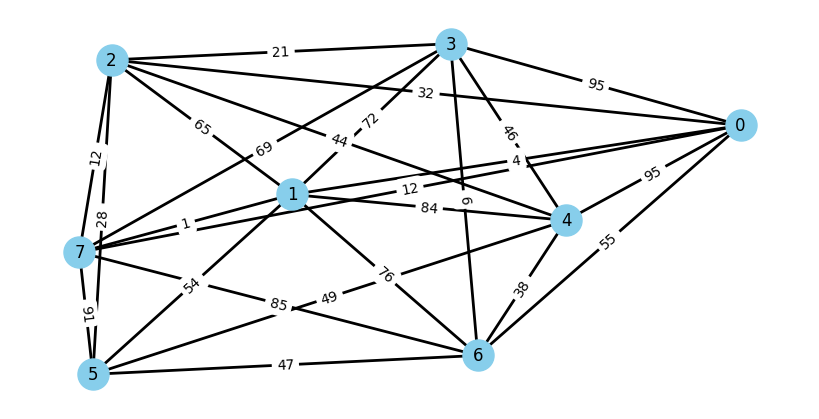

Weight Matrix:


array([[     0,      4,     32,     95,     95, 100000,     55,     12],
       [     4,      0,     65,     72,     84,     54,     76,      1],
       [    32,     65,      0,     21,     44,     28, 100000,     12],
       [    95,     72,     21,      0,     46, 100000,      6,     69],
       [    95,     84,     44,     46,      0,     49,     38, 100000],
       [100000,     54,     28, 100000,     49,      0,     47,     91],
       [    55,     76, 100000,      6,     38,     47,      0,     85],
       [    12,      1,     12,     69, 100000,     91,     85,      0]])

In [ ]:
# Fix the random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Generate a random graph with 7 vertices
num_vertices = 8
graph = generate_graph_with_min_degree_2(num_vertices, prob = 0.8)

# Draw the graph
draw_graph(graph)

# Print the weight matrix
weight_matrix = get_weight_matrix(graph)
print("Weight Matrix:")
weight_matrix

## 2.1 Brute-force solution

TSP problem is NP-hard. The best known exact algorithm is the Held-Karp algorithm [Held and Karp, 1962]. It solves the
problem in time $O\left(n^2 2^n \right)$ and (to the best of our knowledge) it has not been improved in the general setting since then. For details, see e.g.
"Reinforcement Learning for Combinatorial Optimization: A Survey" by
Nina Mazyavkina et al. https://arxiv.org/abs/2003.03600



In [ ]:
import itertools

def solve_tsp_brute_force(weight_matrix):
  """Solves the TSP using brute force."""
  num_vertices = len(weight_matrix)
  min_cost = float('inf')
  best_path = None

  for path in itertools.permutations(range(num_vertices)):
    cost = 0
    for i in range(num_vertices - 1):
      cost += weight_matrix[path[i]][path[i+1]]
    cost += weight_matrix[path[-1]][path[0]]  # Return to the starting city

    if cost < min_cost:
      min_cost = cost
      best_path = path

  return best_path, min_cost


# Solve the TSP using brute force
best_path, min_cost = solve_tsp_brute_force(weight_matrix)

print("Best path found:", best_path)
print("Minimum cost:", min_cost)


Best path found: (0, 1, 5, 4, 6, 3, 2, 7)
Minimum cost: 196


## 2.2 RL in Combinatorial Optimization problems

The next figure outlines reinforcement learning (RL) pipeline for combinatorial optimization (CO) problems.



*   Initially, the CO problem is transformed into a **Markov Decision Process** (MDP) by defining states, actions, and rewards.
*   Then, an **encoder** maps states to numerical vectors.
*   The core of the process is the **RL algorithm**, which teaches the agent how to optimize the encoder and make decisions in the MDP. The reward received after each action is used to update both the encoder and the MDP parameters.



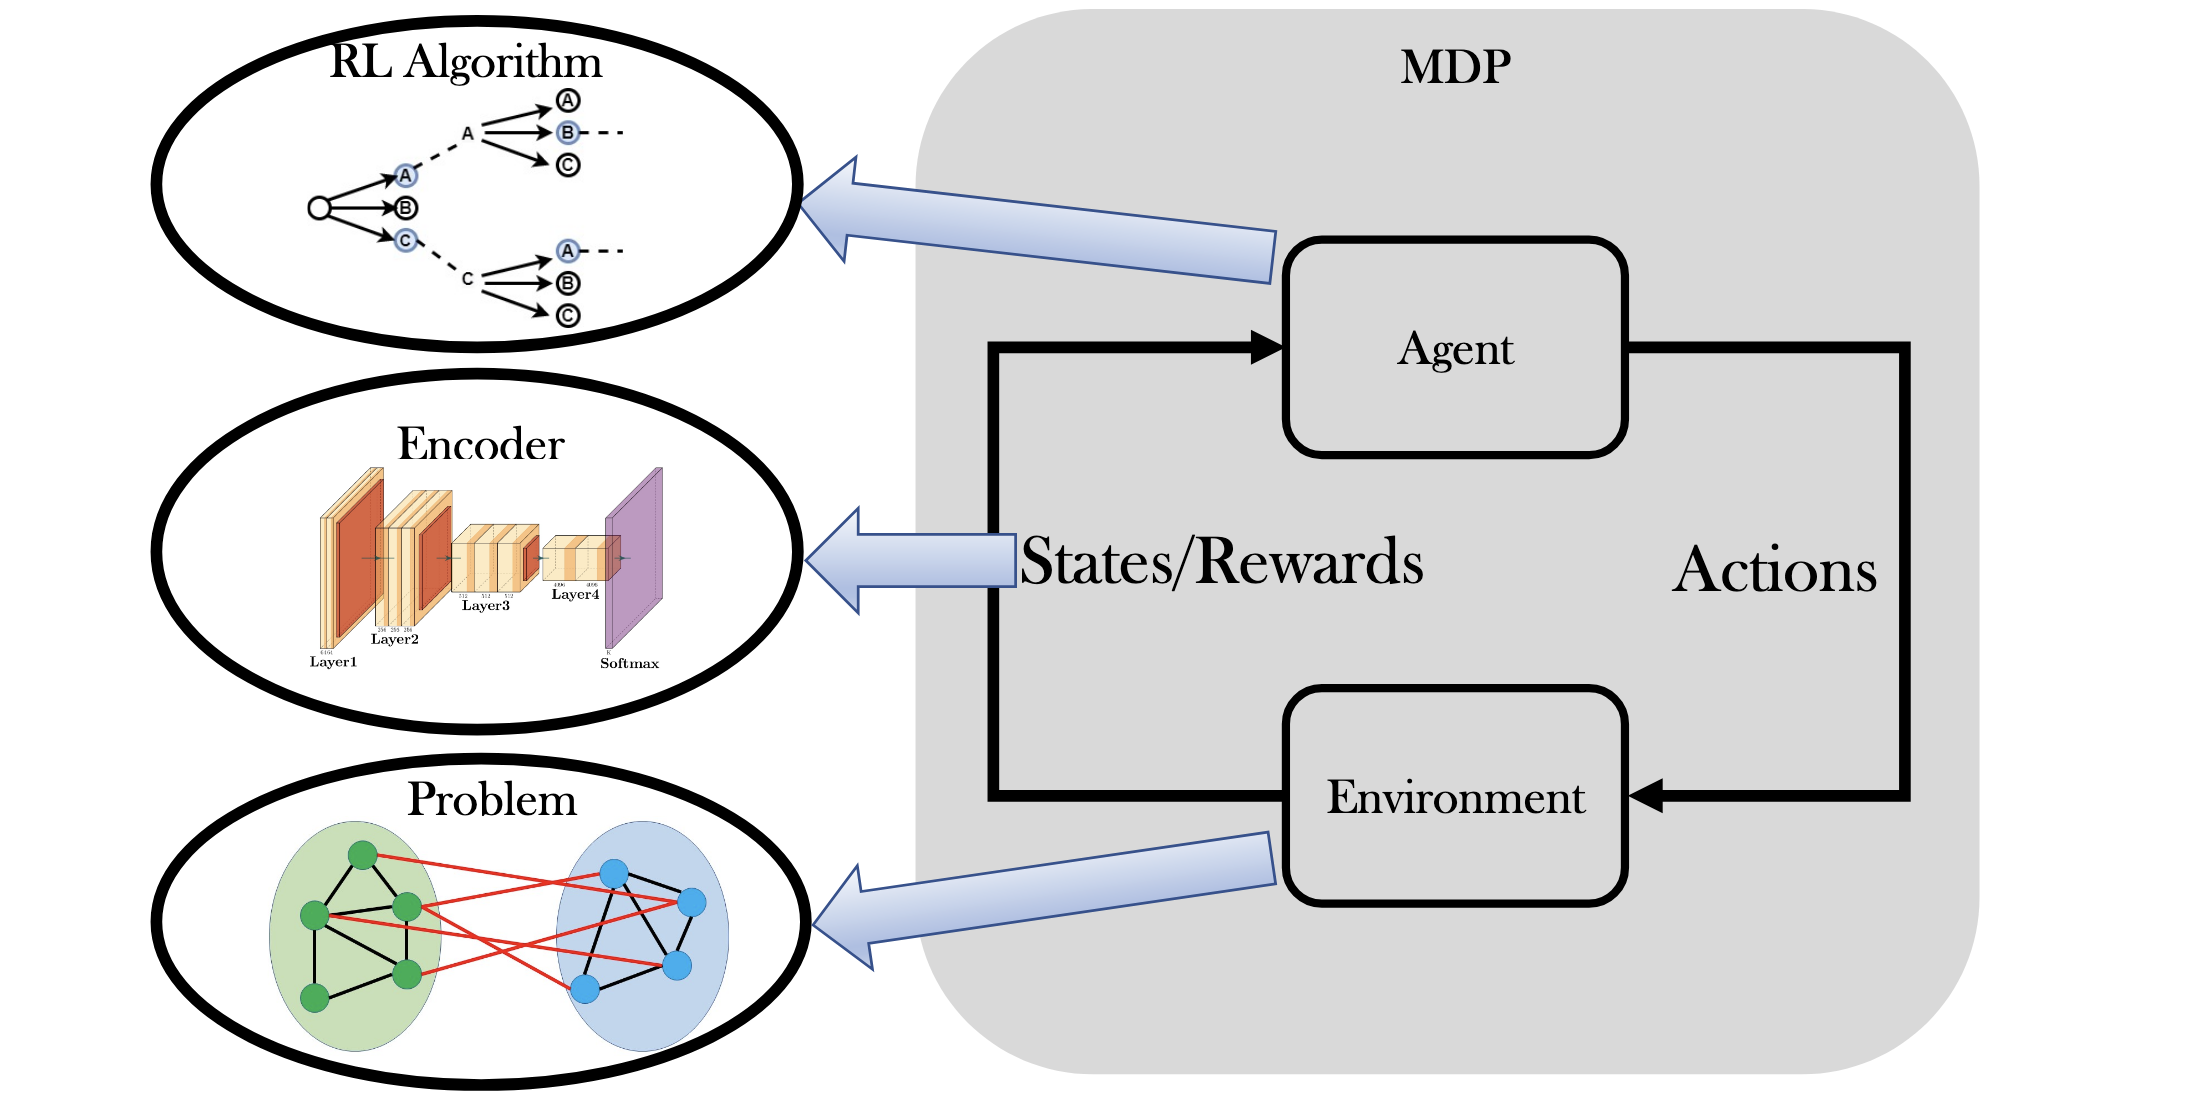

# 3. Cross-Entropy Method

We start with the **Cross-Entropy Method** in RL. Despite its simplicity, it works well in basic environments, it's easy to implement, and it's quite robust against changing hyperparameters, which often makes it an ideal baseline method.

The core of the cross-entropy method is to **throw away bad episodes and train on better ones**. So, the steps of the method are as follows:
1. Play N episodes using our current model and environment.
2. Calculate the total reward for every episode and decide on a reward boundary. Usually, we use a percentile of all rewards, such as the 50th or 70th.
3. Throw away all episodes with a reward below the boundary.
4. Train on the remaining ”elite” episodes (with rewards higher than the boundary) using observations as the input and issued actions as the desired output.
5. Repeat from step 1 until we become satisfied with the result.

The field of RL encompasses a wide array of methods. We'll now examine their different types.

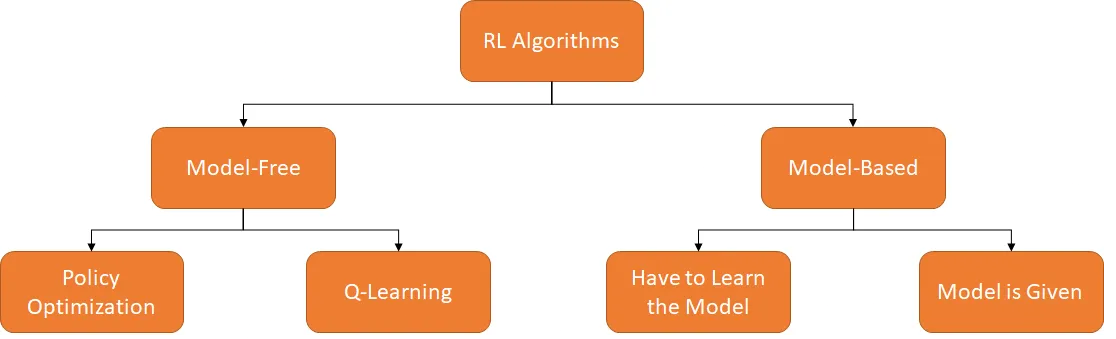

RL methods can be broadly divided into $2$ types:

1. **model-free**, which directly tells the agent what to do without modeling the environment
2. **model-based** (e.g. chess models, where we know the result of each move).


Model-based methods, though harder to train, typically yield superior results. Model-free methods are more versatile.

*   <font color='blue'>**Question**.</font> Is the Cross-Entropy method model-free or model based?


 Model-based methods  can be further divided into 2 categories:

1. **policy-based**, which focuses on approximating the agent's strategy.

2. **value-based**, which focuses on state evaluation.

*   <font color='blue'>**Question**.</font> Is the Cross-Entropy method policy-based or value-based?



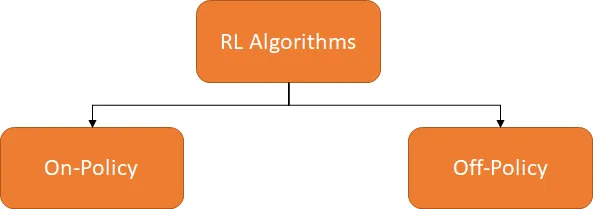

Another RL method division is

* **on-policy** methods, which requires fresh environment data,
* **off-policy** methods, which can utilize any available data.

*   <font color='blue'>**Question**.</font> Is the Cross-Entropy method on-policy or off-policy?

**Remark**. The explanation why CE method works can be found in the the original paper by Kroese , titled `Cross-entropy method` , https://doi.org/10.1002/9780470400531.eorms0210.

## 3.1 Cross-Entropy method for the Travelling Salesman Problem

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

A simple function that computes the total length of a tour.

In [ ]:
def compute_tour_length(tour, dist):
    # Compute the total length of a tour
    total_length = 0
    for i in range(len(tour)):
        start = tour[i]
        end = tour[(i + 1) % len(tour)]
        total_length += dist[start][end]
    return total_length

We use a simple RNN as an encoder.

In [ ]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RNNEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)

    def forward(self, x, hx=None):
        # x shape: (sequence_length, input_dim)
        output, hidden = self.rnn(x, hx)
        return output, hidden

### 3.1.1. Model

We employ a very simple model to predict the next vertex in a path:

*   TSPSolver = RNN + MLP (Linear-ReLU-Linear)

During the training the best paths are saved, and the model's parameters are updated to improve predictions of subsequent vertices based on prior ones.



In [ ]:
class TSPSolver(nn.Module):
    def __init__(self, num_cities, input_dim, hidden_dim):
        super(TSPSolver, self).__init__()
        self.encoder = RNNEncoder(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_cities)

        self.num_cities = num_cities

    def forward(self, coords, hx=None):
        # coords shape: (batch_size, num_cities, input_dim)
        encoded, hidden = self.encoder(coords, hx) # encoded shape: (batch_size, hidden_dim)
        x = F.relu(self.fc1(encoded)) # x shape: (batch_size, hidden_dim)
        logits = self.fc2(x) # logits shape: (batch_size, num_cities)
        return logits

    def sample_tour(self, weight_matrix, start_vertex=0, temperature=1.0):
        # Sampling a complete tour using the model's policy

        tour = [start_vertex]
        remaining = list(range(self.num_cities))
        remaining.remove(start_vertex)


        tour_tensor = torch.tensor([v for v in tour], dtype=torch.float32).unsqueeze(1)


        for _ in range(self.num_cities - 1):
            # Sample from current probabilities
            if len(remaining) == 1:
                city = remaining[0]
            else:
                #coords = weight_matrix[vertex,:]
                # coords_tensor shape = (1, num_cities)
                #coords_tensor = coords.clone().detach().unsqueeze(0)
                logits = self(tour_tensor)[-1,:] #logits shape = (1, num_cities)
                #logits shape = (1, hid_dim)
                # Get the correct shape of probs
                probs = F.softmax(logits / temperature, dim=-1).squeeze(0) # squeezing to remove the batch dimension
                city_probs = torch.zeros(len(remaining))

                for i, r in enumerate(remaining):
                    # Index probs correctly
                    city_probs[i] = probs[r]
                city_probs /= city_probs.sum()
                city = remaining[torch.multinomial(city_probs, 1).item()]
                tour_tensor = torch.tensor([v for v in tour], dtype=torch.float32).unsqueeze(1)


            tour.append(city)
            remaining.remove(city)

        return tour

### 3.1.2. CE method

In [ ]:
def cross_entropy_method(solver, weight_matrix, optimizer,
                         num_iterations=10, population_size=100, elite_fraction=0.2):

    # shape (num_cities, num_cities)
    weight_matrix_tensor = torch.tensor(weight_matrix, dtype=torch.float32)

    best_tour = None
    best_length = float('inf')

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    for iteration in range(num_iterations):
        # Generate a population of tours
        tours = []
        tour_lengths = []

        for _ in range(population_size):
            tour = solver.sample_tour(weight_matrix_tensor) # list with len = num_cities
            tour_length = compute_tour_length(tour, weight_matrix)

            tours.append(tour)
            tour_lengths.append(tour_length)


        # Select elite tours
        num_elite = int(population_size * elite_fraction)
        elite_indices = np.argsort(tour_lengths)[:num_elite]
        elite_tours = [tours[i] for i in elite_indices]
        worst_elite_tour=tour_lengths[elite_indices[-1]]

        # Update best solution
        current_best_length = min(tour_lengths)
        if current_best_length < best_length:
            best_length = current_best_length
            best_tour = tours[np.argmin(tour_lengths)]

        # Train the model on elite tours
        if elite_tours:
            # Reset gradients
            solver.zero_grad()


            for tour in elite_tours:
                for j in range(len(tour)-1):
                    # Prepare input data
                    input_sequence = torch.tensor([city for city in tour[:-1-j]],
                                                  dtype=torch.float32).unsqueeze(1)
                    target_city = torch.tensor(tour[-1-j], dtype=torch.long)

                    # Forward pass
                    output = solver(input_sequence)[-1,:]



                    # Calculate loss
                    loss = criterion(output, target_city)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

        if (iteration + 1) % 1 == 0:
            print(f"Iteration [{iteration+1}/{num_iterations}]")
            print(f"Worst Elite Tour: {worst_elite_tour}")
            print(f"Current Best Tour: {best_tour}")
            print(f"Current Tour Length: {best_length}")

    return worst_elite_tour, best_tour, best_length

### 3.3.3. Application of the model

Our model succefully solves the TSP for this small graph.

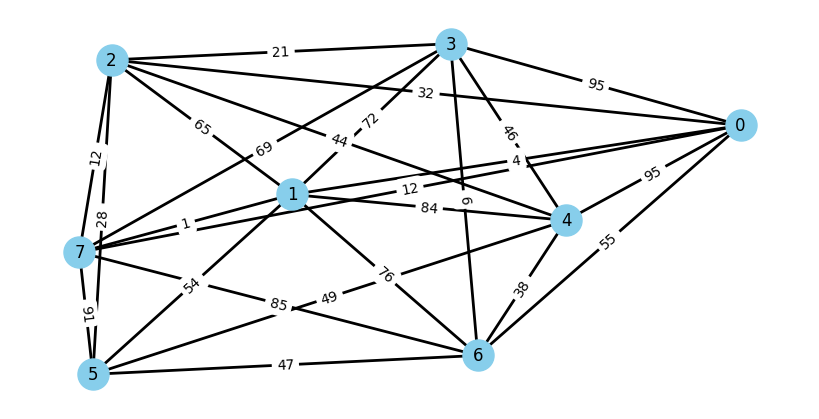

Iteration [1/20]
Worst Elite Tour: 329
Current Best Tour: [0, 7, 1, 5, 2, 3, 4, 6]
Current Tour Length: 255
Iteration [2/20]
Worst Elite Tour: 363
Current Best Tour: [0, 1, 3, 6, 5, 4, 2, 7]
Current Tour Length: 246
Iteration [3/20]
Worst Elite Tour: 309
Current Best Tour: [0, 1, 3, 6, 5, 4, 2, 7]
Current Tour Length: 246
Iteration [4/20]
Worst Elite Tour: 321
Current Best Tour: [0, 1, 3, 6, 5, 4, 2, 7]
Current Tour Length: 246
Iteration [5/20]
Worst Elite Tour: 338
Current Best Tour: [0, 1, 3, 6, 5, 4, 2, 7]
Current Tour Length: 246
Iteration [6/20]
Worst Elite Tour: 319
Current Best Tour: [0, 1, 3, 6, 5, 4, 2, 7]
Current Tour Length: 246
Iteration [7/20]
Worst Elite Tour: 323
Current Best Tour: [0, 7, 2, 5, 4, 6, 3, 1]
Current Tour Length: 221
Iteration [8/20]
Worst Elite Tour: 334
Current Best Tour: [0, 7, 2, 5, 4, 6, 3, 1]
Current Tour Length: 221
Iteration [9/20]
Worst Elite Tour: 297
Current Best Tour: [0, 7, 2, 5, 4, 6, 3, 1]
Current Tour Length: 221
Iteration [10/20]
Worst Elit

In [ ]:
def CE_TSP(num_cities=7, start_city=0, prob = 0.5):
    # Random city coordinates
    random.seed(42)
    np.random.seed(42)

    # Generate a random graph with 7 vertices
    graph = generate_graph_with_min_degree_2(num_cities, prob)
    draw_graph(graph)

    # Initialize solver
    INPUT_DIM = 1
    HIDDEM_DIM = 64
    solver = TSPSolver(num_cities, input_dim=INPUT_DIM, hidden_dim=HIDDEM_DIM)
    optimizer = optim.Adam(solver.parameters(), lr=3e-4)

    weight_matrix = get_weight_matrix(graph)

    # Solve TSP
    worst_best, best_tour, best_length = cross_entropy_method(solver, weight_matrix, optimizer, num_iterations=20, population_size=200, elite_fraction=0.05)

    print(f"Worst Elite Tour: {worst_best}")
    print(f"Best Tour: {best_tour}")
    print(f"Tour Length: {best_length}")

CE_TSP(num_cities=8, prob = 0.8)

SUCCESS!!!

# 4. Farama Gymnasium (Gym interface)

Before applying Reinforcement Learning algorithms to complex real-world problems, it's often beneficial to test them on simpler environments. [Gymnasium](https://github.com/Farama-Foundation/Gymnasium) (the successor to OpenAI Gym) provides a valuable collection of these environments, including robot control, videogames and board games.

Documentation: https://gymnasium.farama.org/

Let's see how it works.

In [ ]:
!pip install gymnasium

In [ ]:
import numpy as np
import gymnasium as gym
from dataclasses import dataclass
import typing as tt
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## 4.1 Frozen Lake Game

The next environment that we will try to solve using the cross- entropy method is **FrozenLake**.

*   Its world is from the so-called grid world category, when your agent lives in  a grid of size $ 4 \times 4$ and can move in four directions: up, down, left, and right.
*   The agent always starts at the top left, and its goal is to reach the bottom-right cell of the grid.
*  There are **holes** in the fixed cells of the grid and if you get into those holes, the episode ends and your reward is zero.
*  If the agent reaches the **destination cell**, then it obtains a reward of 1.0 and the episode ends.

To make life more complicated, by default the world is slippery, so there is a 33% chance that it will slip to the right or to the left. For simplicity we turn this option off.

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", render_mode="rgb_array", is_slippery=False)
env.reset()

(0, {'prob': 1})

Observation space: Discrete(16)
Action space: Discrete(4)


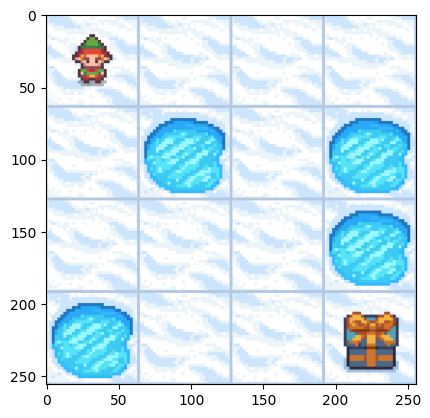

In [ ]:
img = env.render()
plt.imshow(img)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Note: if you're running this on your local machine, you'll see a window pop up with the image above. Don't close it, just alt-tab away.



### 4.1.1 Gymnasium interface



The three main methods of an environment are
* `reset()`: reset environment to the initial state, return first observation and dict with auxiliary info
* `render()`: show current environment state (a more colorful version :) )
* `step(a)`: commit action `a` and return `(new_observation, reward, terminated, truncated, info)`
 * `new_observation`: an observation right after committing the action `a`
 * `reward`: a number representing your reward for committing action `a`
 * `terminated`: True if the MDP has just finished, False if still in progress
 * `truncated`: True if the number of steps elapsed >= max episode steps
 * `info`: some auxiliary stuff about what just happened. For now, ignore it.


A detailed explanation of the difference between `terminated` and `truncated` and how it should be used:
1. https://gymnasium.farama.org/tutorials/gymnasium_basics/handling_time_limits/
2. https://gymnasium.farama.org/content/migration-guide/


In [ ]:
# Set seed to reproduce initial state in stochastic environment
obs0, info = env.reset(seed=0)
print("initial observation code:", obs0)

obs0, info = env.reset(seed=1)
print("initial observation code:", obs0)

initial observation code: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
initial observation code: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Let's make one step.

In [ ]:
print("taking action 2 (right)")
new_obs, reward, terminated, truncated, _ = env.step(2)
print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", terminated)
print("is game truncated due to time limit?:", truncated)

taking action 2 (right)
new observation code: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
reward: 0.0
is game over?: False
is game truncated due to time limit?: False


To process environment positions, we can use "wrappers" that apply one-hot encoding. This means each position is converted into a vector with a single "1" and the rest "0"s, for example, $$(0, \dots, 0, 1, 0, \dots, 0).$$

In [ ]:
class DiscreteOneHotWrapper(gym.ObservationWrapper):
    def __init__(self, env: gym.Env):
        super(DiscreteOneHotWrapper, self).__init__(env)
        assert isinstance(env.observation_space, gym.spaces.Discrete)
        shape = (env.observation_space.n, )
        self.observation_space = gym.spaces.Box(0.0, 1.0, shape, dtype=np.float32)

    def observation(self, observation):
        res = np.copy(self.observation_space.low)
        res[observation] = 1.0
        return res



### 4.2 CE for Frozen-Lake

Our model is a simple FFNN.

In [ ]:
class Net(nn.Module):
    def __init__(self, obs_size: int, hidden_size: int,
                 n_actions: int):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

We make classes to save episode steps and episodes

In [ ]:
@dataclass
class EpisodeStep:
    observation: np.ndarray
    action: int

@dataclass
class Episode:
    reward: float
    steps: tt.List[EpisodeStep]

A function that generates one batch. Each batch consists of

1. The total `reward` (float).
2. A list of `EpisodeStep`.

Each `EpisodeStep` consists of  

*  `observation` (an array), which describes the state,
*  `action` (int) taken in the state.





In [ ]:
def iterate_batches(env: gym.Env, model: Net, batch_size: int) -> \
        tt.Generator[tt.List[Episode], None, None]:
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs, _ = env.reset()
    softmax = nn.Softmax(dim=1)
    while True:
        # choose an action
        obs_v = torch.tensor(obs, dtype=torch.float32)
        act_probs_v = softmax(model(obs_v.unsqueeze(0)))
        act_probs = act_probs_v.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)

        # make step, find reward
        next_obs, reward, is_done, is_trunc, _ = env.step(action)
        episode_reward += float(reward)

        # saving the step
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)

        # save episode if it ended
        if is_done or is_trunc:
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)

            # reset values
            episode_reward = 0.0
            episode_steps = []
            next_obs, _ = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs

Select `percentile` of best episodes. The function returns:

* `train_obs_v` = tensor of observations with shape $(S,D)$, where $X$ total number of actions (= total length of selected episodes) and $D=16$ is the size of vector for the episode.
* `train_act_v` = tensor of taken action with shape $(S)$.
* `reward_bound` = the reward boundary used for filtering.
* `reward_mean` = the mean reward.

In [ ]:
def filter_batch(batch: tt.List[Episode], percentile: float) -> \
        tt.Tuple[torch.FloatTensor, torch.LongTensor, float, float]:
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = float(np.percentile(rewards, percentile))
    reward_mean = float(np.mean(rewards))

    train_obs: tt.List[np.ndarray] = []
    train_act: tt.List[int] = []
    for episode in batch:
        if episode.reward < reward_bound:
            continue

        train_obs.extend(map(lambda step: step.observation,
                             episode.steps))
        train_act.extend(map(lambda step: step.action,
                             episode.steps))

    train_obs_v = torch.FloatTensor(np.vstack(train_obs))
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean

Parameters of the model

In [ ]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70
MAX_ITER = 2000
LR = 0.01

Application of the model

In [ ]:
env = DiscreteOneHotWrapper(gym.make("FrozenLake-v1", desc=None, map_name="4x4",
                                     render_mode="rgb_array", is_slippery=False))
obs_size = env.observation_space.shape[0]
n_actions = int(env.action_space.n)

net = Net(obs_size, HIDDEN_SIZE, n_actions)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=LR)

for iter_no, batch in enumerate(
        iterate_batches(env, net, BATCH_SIZE)):


    # We perform filtering of the elite episodes using the
    # function. The result is tensors of observations and taken actions,
    # the reward boundary used for filtering, and the mean reward.

    obs_v, acts_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
    optimizer.zero_grad()

    # calculate action scores
    action_scores_v = net(obs_v)

    # Calculate Cross-Entropy between the NN output and the actions that the agent took.
    # The idea is to reinforce our NN to carry out the elite actions that have led to good rewards.
    loss_v = objective(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()
    if iter_no % 200 == 0:
        print("%d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
    if reward_m > 0.8:
        print("Solved!")
        break
    if iter_no > MAX_ITER:
        print("NOT solved!")
        break

0: loss=1.383, reward_mean=0.1, reward_bound=0.0
200: loss=0.883, reward_mean=0.0, reward_bound=0.0
400: loss=0.111, reward_mean=0.0, reward_bound=0.0
600: loss=0.001, reward_mean=0.0, reward_bound=0.0
800: loss=0.006, reward_mean=0.0, reward_bound=0.0
1000: loss=0.003, reward_mean=0.0, reward_bound=0.0
1200: loss=0.001, reward_mean=0.0, reward_bound=0.0
1400: loss=0.000, reward_mean=0.0, reward_bound=0.0
1600: loss=0.081, reward_mean=0.0, reward_bound=0.0


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

frames = []

obs = env.reset()
if isinstance(obs, tuple):
    obs = obs[0]

while True:
    # Render before action
    frame = env.render()
    frames.append(frame)

    obs_v = torch.FloatTensor([obs])
    logits = net(obs_v)
    action = torch.argmax(logits, dim=1).item()

    obs, reward, done, *_ = env.step(action)
    if isinstance(obs, tuple):
        obs = obs[0]

    if done:
        # One final render *after* last step
        frame = env.render()
        frames.append(frame)
        break

# Play back all frames
for frame in frames:
    plt.imshow(frame)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.3)

print(f"Episode reward: {reward}")

KeyboardInterrupt: 

We can see that our training process *doesn't improve the score over time*.


<font color='red'>Problems.</font>

*   In the FrozenLake environment we get the reward of 1.0 only when we reach the goal, and this reward says nothing about how good each episode was.
*   There are only two kinds of episodes possible, with zero reward (failed) and one reward (successful), and failed episodes will obviously dominate at the beginning of the training, when the agent acts randomly.

This example shows us the <font color='red'>limitations of the cross-entropy method</font> :
1. For training, our episodes have to be finite (in general, they could be infinite) and, preferably, short.
2. The total reward for the episodes should have enough variability to separate good episodes from bad ones.
3. It is beneficial to have an intermediate reward during the episode instead of having the reward at the end of the episode.




## 4.3 Fixing CE for Frozen Lake (optional)

Troubleshooting RL problems can be extremely challenging, often requiring a lot of "duck tape" and ad hoc modifications.

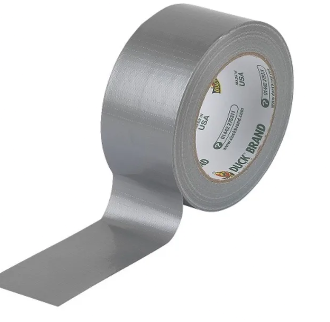

We'll briefly list potential fixes, omitting detailed explanations.

1. Larger batches of played episodes.
2. Discount factor applied to the reward.
3. Keeping elite episodes for a longer time.
4. Decreasing the learning rate.
5. A more complex model.
6. Much longer training time (!).

# 5. Constructions in combinatorics via neural networks

In the paper  "Constructions in combinatorics via neural networks" by A Z Wagner https://arxiv.org/abs/2104.14516 CE method was used for constructions of counter-examples in combinatorics.

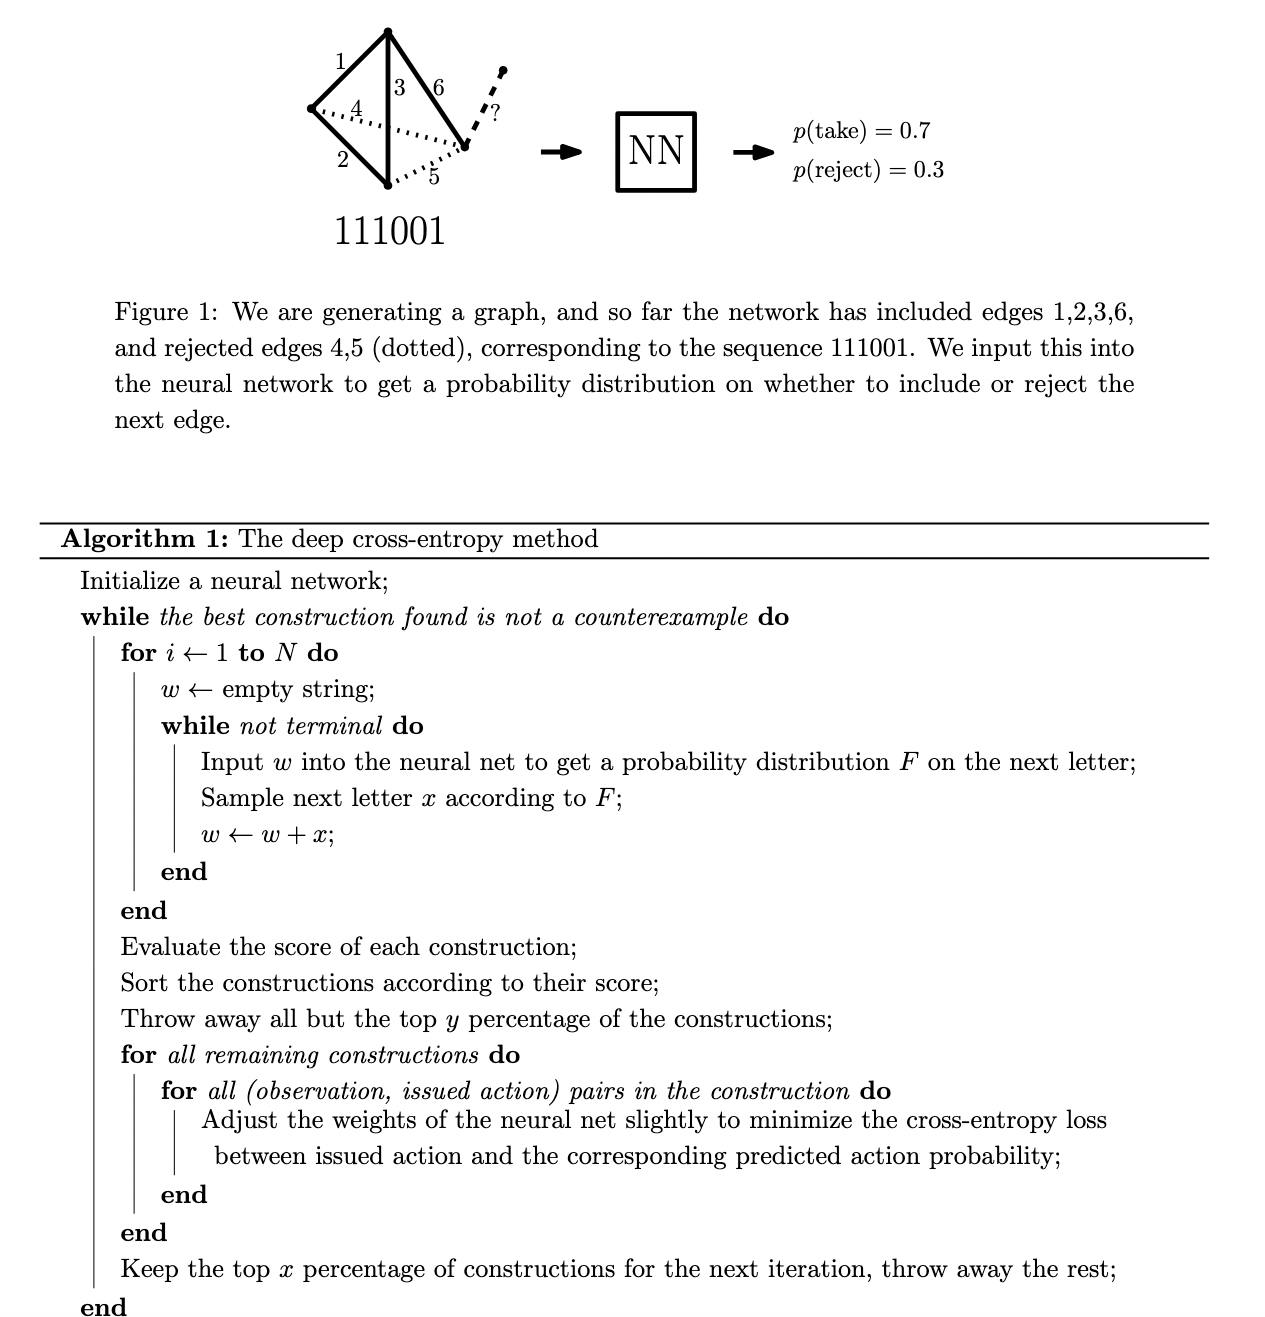

This paper has several implementations https://paperswithcode.com/paper/constructions-in-combinatorics-via-neural We will use the implementation from https://github.com/dpaleka/cross-entropy-for-combinatorics



*   For simplicity, we will **minimize the absolute ratio of the first and the last eigenvalue** of the adjacency matrix of a connected graph. (This will just generate connected bipartite graphs after a few iterations.)


In [ ]:
import networkx as nx #for various graph parameters, such as eigenvalues, macthing number, etc. Does not work with numba (yet)
import random
import numpy as np
from statistics import mean
import pickle
import time
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import itertools
from tqdm import trange, tqdm
import math

Invariants

In [ ]:
N = 20   #number of vertices in the graph. Only used in the reward function, not directly relevant to the algorithm
MYN = int(N*(N-1)/2)  #The length of the word we are generating. Here we are generating a graph, so we create a 0-1 word of length (N choose 2)

LEARNING_RATE = 0.01 #Increase this to make convergence faster, decrease if the algorithm gets stuck in local optima too often.
n_sessions = 200 #number of new sessions per iteration
percentile = 93 #top 100-X percentile we are learning from
super_percentile = 94 #top 100-X percentile that survives to next iteration

FIRST_LAYER_NEURONS = 128 #Number of neurons in the hidden layers.
SECOND_LAYER_NEURONS = 64
THIRD_LAYER_NEURONS = 4

n_actions = 2 #The size of the alphabet. In this file we will assume this is 2. There are a few things we need to change when the alphabet size is larger,
              #such as one-hot encoding the input, and using categorical_crossentropy as a loss function.

observation_space = 2*MYN #Leave this at 2*MYN. The input vector will have size 2*MYN, where the first MYN letters encode our partial word (with zeros on
                          #the positions we haven't considered yet), and the next MYN bits one-hot encode which letter we are considering now.
                          #So e.g. [0,1,0,0,   0,0,1,0] means we have the partial word 01 and we are considering the third letter now.

len_game = MYN
state_dim = (observation_space,)

## Model

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, widths):
        super().__init__()

        num_layers = len(widths)
        layers = [[nn.Linear(widths[i], widths[i+1]), nn.ReLU()] for i in range(num_layers-2)]
        self.layers = [nn.Flatten(1, -1),
                      *list(itertools.chain(*layers)),
                      nn.Linear(widths[-2], widths[-1]),
                      nn.Sigmoid()]

        print(self.layers)
        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        prob = self.net(x)
        return prob

In [ ]:
# A sequential network with three hidden layers, sigmoid activation in the output.
# It is important that the loss is binary cross-entropy if alphabet size is 2.
model = DenseNet([2*MYN, FIRST_LAYER_NEURONS, SECOND_LAYER_NEURONS, THIRD_LAYER_NEURONS, 1])

# Expertiment: try ADAM optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=380, out_features=128, bias=True), ReLU(), Linear(in_features=128, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=4, bias=True), ReLU(), Linear(in_features=4, out_features=1, bias=True), Sigmoid()]


Training loop

In [ ]:
def train_network(model, optimizer, train_loader,
                  num_epochs=1, pbar_update_interval=200, print_logs=False):
    '''
    Updates the model parameters (in place) using the given optimizer object.
    Returns `None`.
    '''

    criterion = nn.BCELoss()
    pbar = trange(num_epochs) if print_logs else range(num_epochs)

    for i in pbar:
        for k, batch_data in enumerate(train_loader):
            batch_x = batch_data[:, :-1]
            batch_y = batch_data[:, -1]
            model.zero_grad()
            y_pred = model(batch_x)
            loss = criterion(y_pred, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            if print_logs and k % pbar_update_interval == 0:
                acc = (y_pred.round() == batch_y).sum().float()/(len(batch_y))
                pbar.set_postfix(loss=loss.item(), acc=acc.item())

In [ ]:
def state_to_graph(state):
    #construct the graph G
    adjMatG = np.zeros((N,N),dtype=np.int8) #adjacency matrix determined by the state
    edgeListG = np.zeros((N,N),dtype=np.int8) #neighbor list
    Gdeg = np.zeros(N,dtype=np.int8) #degree sequence
    count = 0
    for i in range(N):
        for j in range(i+1,N):
            if state[count] == 1:
                adjMatG[i][j] = 1
                adjMatG[j][i] = 1
                edgeListG[i][Gdeg[i]] = j
                edgeListG[j][Gdeg[j]] = i
                Gdeg[i] += 1
                Gdeg[j] += 1
            count += 1

    return adjMatG, edgeListG, Gdeg

In [ ]:
from numba import njit


@njit
def bfs(Gdeg,edgeListG):
    #simple breadth first search algorithm, from each vertex
    N = Gdeg.size

    distMat1 = np.zeros((N,N))
    conn = True
    for s in range(N):
        visited = np.zeros(N,dtype=np.int8)

        # Create a queue for BFS. Queues are not suported with njit yet so do it manually
        myQueue = np.zeros(N,dtype=np.int8)
        dist = np.zeros(N,dtype=np.int8)
        startInd = 0
        endInd = 0

        # Mark the source node as visited and enqueue it
        myQueue[endInd] = s
        endInd += 1
        visited[s] = 1

        while endInd > startInd:
            pivot = myQueue[startInd]
            startInd += 1

            for i in range(Gdeg[pivot]):
                if visited[edgeListG[pivot][i]] == 0:
                    myQueue[endInd] = edgeListG[pivot][i]
                    dist[edgeListG[pivot][i]] = dist[pivot] + 1
                    endInd += 1
                    visited[edgeListG[pivot][i]] = 1
        if endInd < N:
            conn = False #not connected

        for i in range(N):
            distMat1[s][i] = dist[i]

    return distMat1, conn

In [ ]:
def score_graph(adjMatG, edgeListG, Gdeg):
    """
    Reward function. The arguments adjMatG, edgeListG, Gdeg are numpy arrays.
    """
    N = Gdeg.size
    INF = 100000

    _, conn = bfs(Gdeg,edgeListG)
    if not conn:
        return -INF

    lambdas = np.flip(np.sort(np.linalg.eigvals(adjMatG)))
    return -abs(lambdas[0]/lambdas[-1])


def score_state(state):
    return score_graph(*state_to_graph(state))

In [ ]:
def display_graph(adjMatG):
    print("Best adjacency matrix in current step:")
    print(adjMatG)

    G = nx.convert_matrix.from_numpy_array(adjMatG)

    plt.clf()
    nx.draw_circular(G)

    plt.axis('equal')
    plt.draw()
    plt.pause(0.001)
    plt.show()


def display_graph(adjMatG):
    print("Best adjacency matrix in current step:")
    print(adjMatG)

    G = nx.convert_matrix.from_numpy_array(adjMatG)

    # Try bipartite coloring first
    if nx.is_bipartite(G):
        print("Graph is bipartite. Using 2-coloring.")
        color_map = {}
        left, right = nx.bipartite.sets(G)
        for node in left:
            color_map[node] = 0
        for node in right:
            color_map[node] = 1
        num_colors = 2
    else:
        print("Graph is not bipartite. Using greedy coloring.")
        color_map = nx.coloring.greedy_color(G, strategy="largest_first")
        num_colors = len(set(color_map.values()))

    print(f"Graph colored with {num_colors} colors.")

    # Map color indices to matplotlib colors
    color_list = plt.cm.tab10.colors
    node_colors = [color_list[color_map[node] % len(color_list)] for node in G.nodes()]

    # Draw graph with colored nodes
    plt.clf()
    nx.draw_circular(G, with_labels=True, node_color=node_colors, edgecolors='black')

    plt.axis('equal')
    plt.draw()
    plt.pause(0.001)
    plt.show()

In [ ]:
def play_game(n_sessions, actions,state_next,states,prob, step, total_score):

    for i in range(n_sessions):
        if np.random.rand() < prob[i]:
            action = 1
        else:
            action = 0
        actions[i][step-1] = action
        state_next[i] = states[i,:,step-1]

        if (action > 0):
            state_next[i][step-1] = action
        state_next[i][MYN + step-1] = 0
        if (step < MYN):
            state_next[i][MYN + step] = 1
        #calculate final score
        terminal = step == MYN
        if terminal:
            total_score[i] = score_state(state_next[i])

        # record sessions
        if not terminal:
            states[i,:,step] = state_next[i]

    return actions, state_next,states, total_score, terminal

In [ ]:
def generate_session(agent, n_sessions, verbose = 1):
    """
    Play n_session games using agent neural network.
    Terminate when games finish

    Code inspired by https://github.com/yandexdataschool/Practical_RL/blob/master/week01_intro/deep_crossentropy_method.ipynb
    """
    states =  np.zeros([n_sessions, observation_space, len_game], dtype=int)
    actions = np.zeros([n_sessions, len_game], dtype = int)
    state_next = np.zeros([n_sessions,observation_space], dtype = int)
    prob = np.zeros(n_sessions)
    states[:,MYN,0] = 1
    step = 0
    total_score = np.zeros([n_sessions])
    pred_time = 0
    play_time = 0

    while (True):
        step += 1
        tic = time.time()
        prob = agent(torch.from_numpy(states[:,:,step-1]).to(torch.float))
        prob = prob.detach().cpu().numpy()

        pred_time += time.time()-tic
        tic = time.time()
        actions, state_next, states, total_score, terminal = play_game(
                n_sessions, actions,state_next, states,prob, step, total_score)
        play_time += time.time()-tic

        if terminal:
            break
    if (verbose):
        print("Predict: "+str(pred_time)+", play: " + str(play_time))
    return states, actions, total_score

In [ ]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    This function was mostly taken from https://github.com/yandexdataschool/Practical_RL/blob/master/week01_intro/deep_crossentropy_method.ipynb
    If this function is the bottleneck, it can easily be sped up using numba
    """
    counter = n_sessions * (100.0 - percentile) / 100.0
    reward_threshold = np.percentile(rewards_batch,percentile)

    elite_states = []
    elite_actions = []
    elite_rewards = []
    for i in range(len(states_batch)):
        if rewards_batch[i] >= reward_threshold-0.0000001:
            if (counter > 0) or (rewards_batch[i] >= reward_threshold+0.0000001):
                for item in states_batch[i]:
                    elite_states.append(item.tolist())
                for item in actions_batch[i]:
                    elite_actions.append(item)
            counter -= 1
    elite_states = np.array(elite_states, dtype = int)
    elite_actions = np.array(elite_actions, dtype = int)
    return elite_states, elite_actions

def select_super_sessions(states_batch, actions_batch, rewards_batch, percentile=90):
    """
    Select all the sessions that will survive to the next generation
    Similar to select_elites function
    If this function is the bottleneck, it can easily be sped up using numba
    """

    counter = n_sessions * (100.0 - percentile) / 100.0
    reward_threshold = np.percentile(rewards_batch,percentile)

    super_states = []
    super_actions = []
    super_rewards = []
    for i in range(len(states_batch)):
        if rewards_batch[i] >= reward_threshold-0.0000001:
            if (counter > 0) or (rewards_batch[i] >= reward_threshold+0.0000001):
                super_states.append(states_batch[i])
                super_actions.append(actions_batch[i])
                super_rewards.append(rewards_batch[i])
                counter -= 1
    super_states = np.array(super_states, dtype = int)
    super_actions = np.array(super_actions, dtype = int)
    super_rewards = np.array(super_rewards)
    return super_states, super_actions, super_rewards


1. Best individuals: [-1.74502924 -1.83227012 -1.84117989 -1.84545539 -1.90390662 -1.90701751
 -1.92693507 -1.92709526 -1.93739515 -1.95509285 -1.95595902 -1.95711663
 -1.95944055]
Mean reward: -2.134175762103568
Sessgen: 1.3464434146881104, other: 0.10632944107055664, select1: 0.08580708503723145, select2: 0.0020956993103027344, select3: 5.364418029785156e-05, fit: 0.1457676887512207, score: 0.00014662742614746094
Best adjacency matrix in current step:
[[0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1]
 [0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0]
 [0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1]
 [0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0]
 [1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0]
 [1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1]
 [1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1]
 [1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0]
 [1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0]
 [0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1]
 [1 0 0 1 1 0 0 1 1 0 1 0

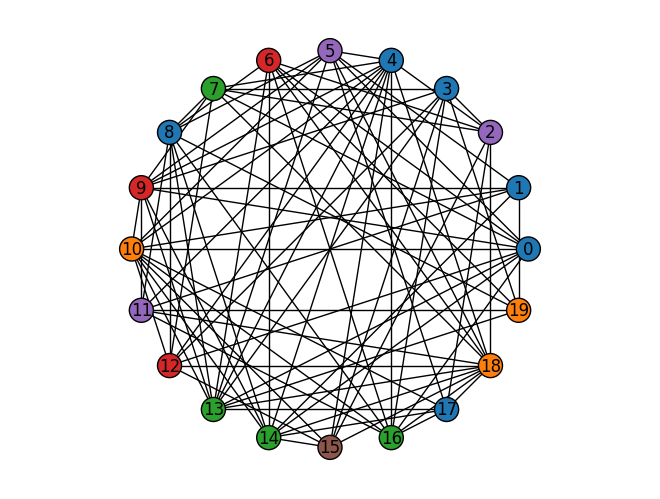


21. Best individuals: [-1.28712005 -1.29673244 -1.31036858 -1.31057482 -1.34435177 -1.3478821
 -1.37133212 -1.37622758 -1.38224918 -1.38695503 -1.38998079 -1.39010326
 -1.39347159]
Mean reward: -1.52357046196577
Sessgen: 1.3777520656585693, other: 0.1378023624420166, select1: 0.06501150131225586, select2: 0.0020592212677001953, select3: 3.170967102050781e-05, fit: 0.14175987243652344, score: 0.00015783309936523438
Best adjacency matrix in current step:
[[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1]
 [0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1]
 [0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
 [0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0]
 [0 1 0 1 0 1 0 0 1 0 0 0 

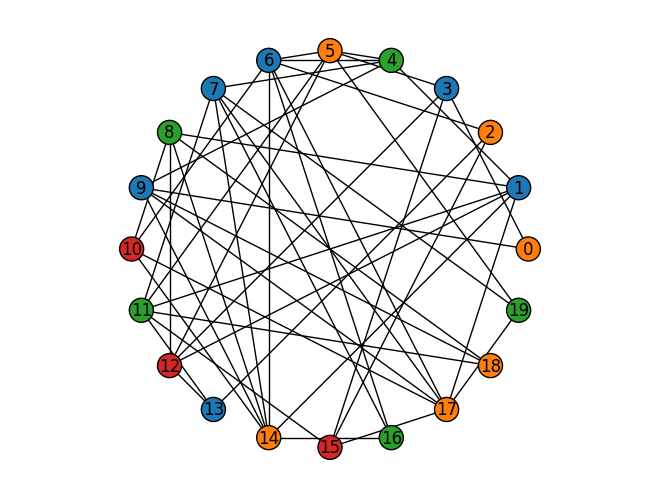


41. Best individuals: [-1.         -1.         -1.01291303 -1.0179286  -1.02550261 -1.02588164
 -1.03072895 -1.03419481 -1.03720163 -1.04020751 -1.04489779 -1.04677343
 -1.0472906 ]
Mean reward: -14001.03150173116
Sessgen: 1.4385924339294434, other: 0.11906290054321289, select1: 0.08528280258178711, select2: 0.002825498580932617, select3: 4.410743713378906e-05, fit: 0.1561722755432129, score: 0.0001678466796875
Best adjacency matrix in current step:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0

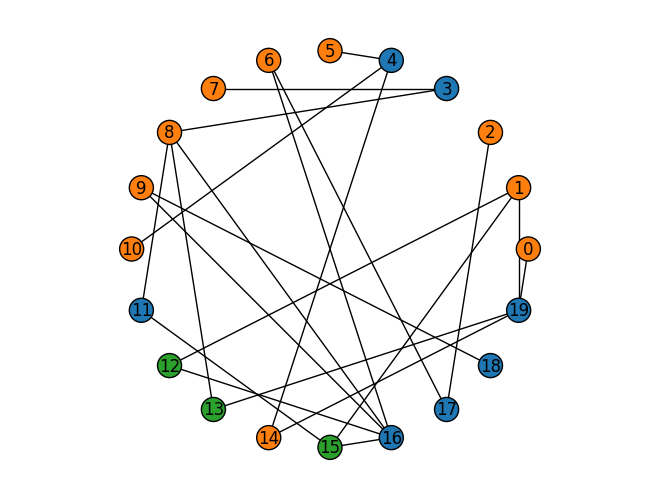

In [ ]:
super_states =  np.empty((0,len_game,observation_space), dtype = int)
super_actions = np.array([], dtype = int)
super_rewards = np.array([])
sessgen_time = 0
fit_time = 0
score_time = 0


myRand = random.randint(0,1000) #used in the filename

NUM_SESSIONS = 200
for i in range(NUM_SESSIONS): #increase NUM_SESSIONS if necessary
    #generate new sessions
    #performance can be improved with joblib
    tic = time.time()
    sessions = generate_session(model,n_sessions,0) #change 0 to 1 to print out how much time each step in generate_session takes
    sessgen_time = time.time()-tic
    tic = time.time()

    states_batch = np.array(sessions[0], dtype = int)
    actions_batch = np.array(sessions[1], dtype = int)
    rewards_batch = np.array(sessions[2])
    states_batch = np.transpose(states_batch,axes=[0,2,1])

    states_batch = np.append(states_batch,super_states,axis=0)

    if i>0:
        actions_batch = np.append(actions_batch,np.array(super_actions),axis=0)
    rewards_batch = np.append(rewards_batch,super_rewards)

    randomcomp_time = time.time()-tic
    tic = time.time()

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) #pick the sessions to learn from
    select1_time = time.time()-tic

    tic = time.time()
    super_sessions = select_super_sessions(states_batch, actions_batch, rewards_batch, percentile=super_percentile) #pick the sessions to survive
    select2_time = time.time()-tic

    tic = time.time()
    super_sessions = [(super_sessions[0][i], super_sessions[1][i], super_sessions[2][i]) for i in range(len(super_sessions[2]))]
    super_sessions.sort(key=lambda super_sessions: super_sessions[2],reverse=True)
    select3_time = time.time()-tic

    tic = time.time()

    train_data = torch.from_numpy(np.column_stack((elite_states, elite_actions)))
    train_data = train_data.to(torch.float)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)
    train_network(model, optimizer, train_loader)
    fit_time = time.time()-tic

    tic = time.time()

    super_states = [super_sessions[i][0] for i in range(len(super_sessions))]
    super_actions = [super_sessions[i][1] for i in range(len(super_sessions))]
    super_rewards = [super_sessions[i][2] for i in range(len(super_sessions))]

    rewards_batch.sort()
    mean_all_reward = np.mean(rewards_batch[-100:])
    mean_best_reward = np.mean(super_rewards)

    score_time = time.time()-tic

    if (i%20 == 1):
        print("\n" + str(i) +  ". Best individuals: " + str(np.flip(np.sort(super_rewards))))

        #uncomment below line to print out how much time each step in this loop takes.
        print(    "Mean reward: " + str(mean_all_reward) + "\nSessgen: " + str(sessgen_time) + ", other: " + str(randomcomp_time) + ", select1: " + str(select1_time) + ", select2: " + str(select2_time) + ", select3: " + str(select3_time) +  ", fit: " + str(fit_time) + ", score: " + str(score_time))


        display_graph(state_to_graph(super_actions[0])[0])

    if (i%20 == 1): #Write all important info to files every 20 iterations
        with open('best_species_pickle_'+str(myRand)+'.txt', 'wb') as fp:
            pickle.dump(super_actions, fp)
        with open('best_species_txt_'+str(myRand)+'.txt', 'w') as f:
            for item in super_actions:
                f.write(str(item))
                f.write("\n")
        with open('best_species_rewards_'+str(myRand)+'.txt', 'w') as f:
            for item in super_rewards:
                f.write(str(item))
                f.write("\n")
        with open('best_100_rewards_'+str(myRand)+'.txt', 'a') as f:
            f.write(str(mean_all_reward)+"\n")
        with open('best_elite_rewards_'+str(myRand)+'.txt', 'a') as f:
            f.write(str(mean_best_reward)+"\n")
    if (i%200==2): # To create a timeline, like in Figure 3
        with open('best_species_timeline_txt_'+str(myRand)+'.txt', 'a') as f:
            f.write(str(super_actions[0]))
            f.write("\n")

## 5.1 Conclusion

We minimized the absolute ratio of the first and the last eigenvalue of the adjacency matrix. Let's check that our model generates **connected bipartite graphs**.


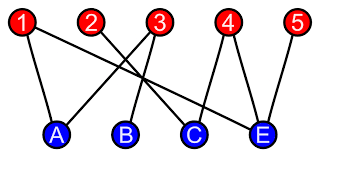

In [ ]:
def is_bipartite(adjMatG):
  """
  Checks if a graph is bipartite using a breadth-first search algorithm.
  """
  num_vertices = len(adjMatG)
  color = [-1] * num_vertices  # -1: uncolored, 0: color 1, 1: color 2

  def bfs(start_node):
    queue = [start_node]
    color[start_node] = 0

    while queue:
      node = queue.pop(0)
      for neighbor in range(num_vertices):
        if adjMatG[node][neighbor] == 1:
          if color[neighbor] == -1:
            color[neighbor] = 1 - color[node]
            queue.append(neighbor)
          elif color[neighbor] == color[node]:
            return False  # Not bipartite
    return True

  for node in range(num_vertices):
    if color[node] == -1:
      if not bfs(node):
        return False

  return True

# Example usage (assuming you have adjMatG defined)
adjMatG = state_to_graph(super_actions[0])[0]
if is_bipartite(adjMatG):
  print("The graph is bipartite.")
else:
  print("The graph is not bipartite.")

This result aligns with theory. Let $\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_n$ be the eigenvalues of the adjacency matrix.

*   On one hand, by the Perron-Frobenius theorem, $\lambda_1 \geq - \lambda_n$.
*   On the other hand, for a connected graph $\lambda_n = - \lambda_1$ if and only if it is bipartite.

For details, see e.g. https://jasoncantarella.com/downloads/sagt-interlacing.pdf
